In [2]:
# importing libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import seaborn as sns
sns.set_context("talk")

# Load data

In [3]:
df = pd.read_csv(
    "example_retail_sales.csv", parse_dates=["ds"], index_col=["ds"]
)
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


Text(0, 0.5, 'Retail Sales')

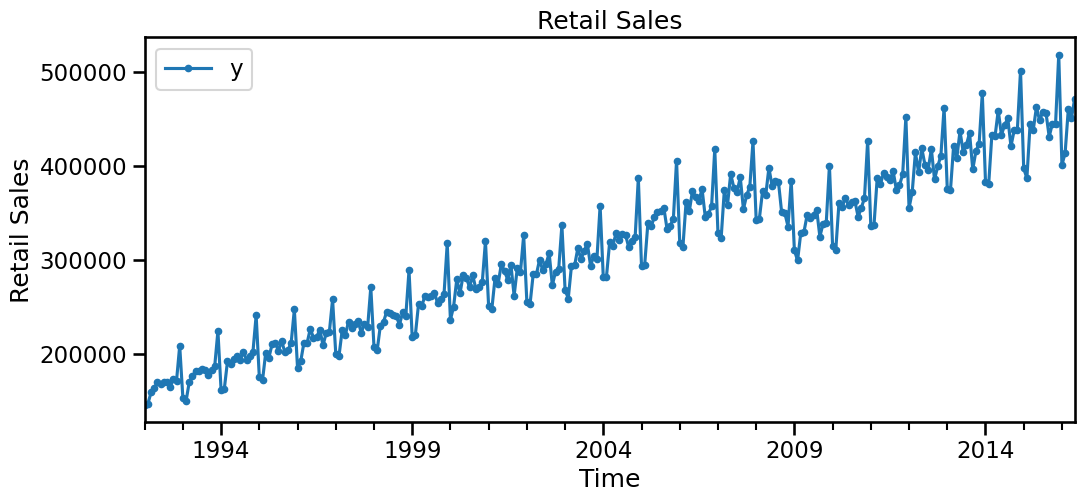

In [4]:
ax = df.plot(marker=".", figsize=[12, 5])
ax.set_title("Retail Sales")
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")

# STL decomposition from scratch

### Step 1: Find the approximate trend line

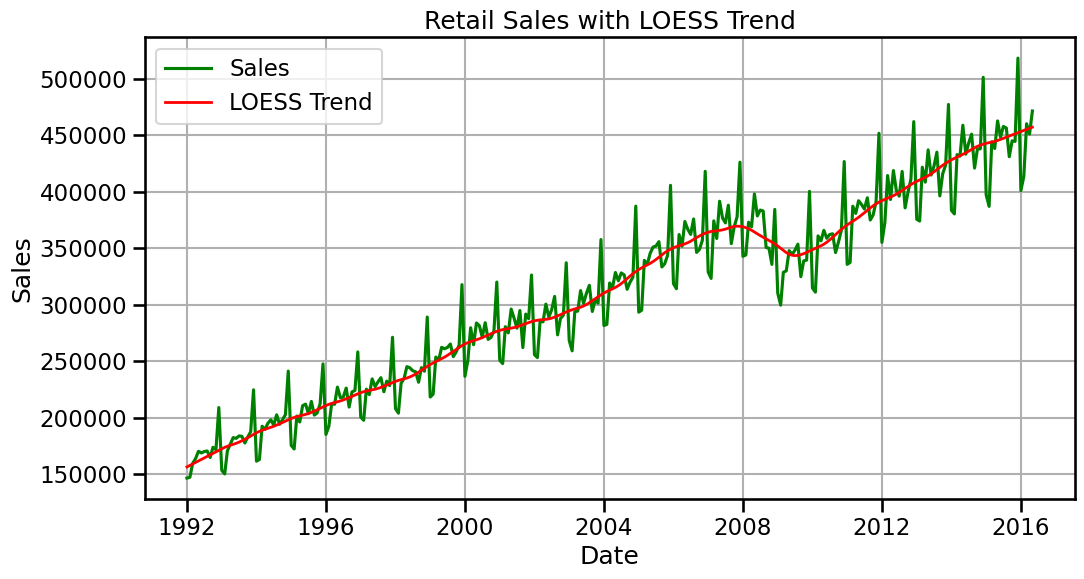

In [5]:
# Generate a LOESS smoothed trend line
lowess = sm.nonparametric.lowess
trend = lowess(df['y'], df.index, frac=0.1)

# Plotting the time series and trend
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Sales', color='green')
plt.plot(df.index, trend[:, 1], label='LOESS Trend', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Retail Sales with LOESS Trend')
plt.legend()
plt.grid(True)
plt.show()


### Step 2: Find the De-trended series

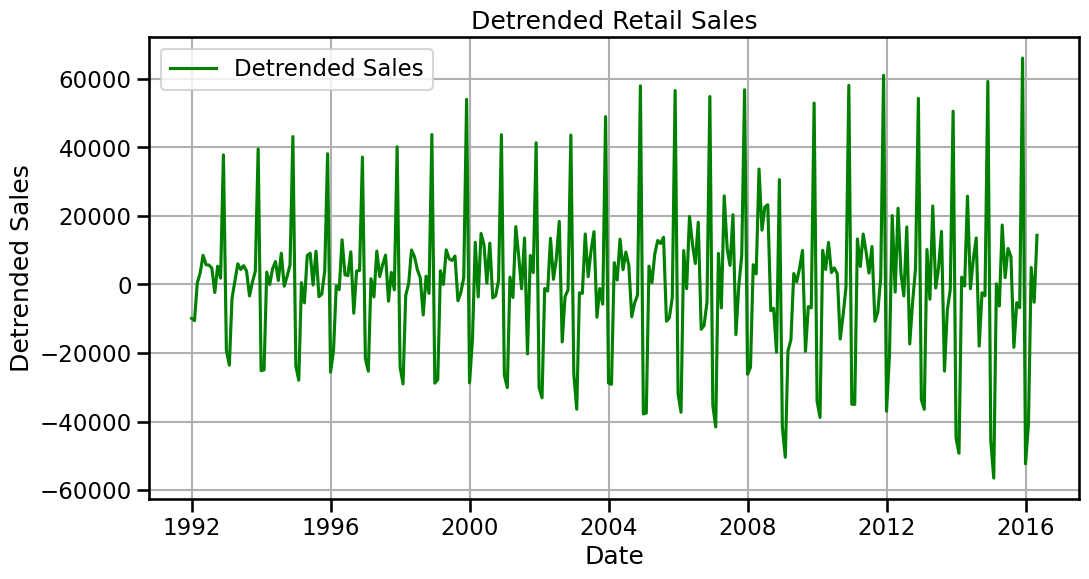

,y,Detrended_Sales
ds,,
1992-01-01,146376,-9867.927417
1992-02-01,147079,-10543.640842
1992-03-01,159336,438.292443
1992-04-01,163669,3418.535832
1992-05-01,170068,8512.243622


In [6]:
# Detrending the series by subtracting the trend from the original data
detrended_series = df['y'] - trend[:, 1]

# Plotting the detrended series
plt.figure(figsize=(12, 6))
plt.plot(df.index, detrended_series, label='Detrended Sales', color='green')
plt.xlabel('Date')
plt.ylabel('Detrended Sales')
plt.title('Detrended Retail Sales')
plt.legend()
plt.grid(True)
plt.show()


# Add the detrended series as a new column to the original DataFrame
df['Detrended_Sales'] = detrended_series

# Display the updated DataFrame with the new column
df.head()



### Step 3: Find the seasonal component

In [7]:
# Average over each month
df["month"] = df.index.month
df.head()


,y,Detrended_Sales,month
ds,,,
1992-01-01,146376,-9867.927417,1
1992-02-01,147079,-10543.640842,2
1992-03-01,159336,438.292443,3
1992-04-01,163669,3418.535832,4
1992-05-01,170068,8512.243622,5


### Gather the cycle subseries for each month across all years.
### Apply LOESS smoothing to each month's subseries.
### Plot all 12 subseries with their respective smoothed curves.

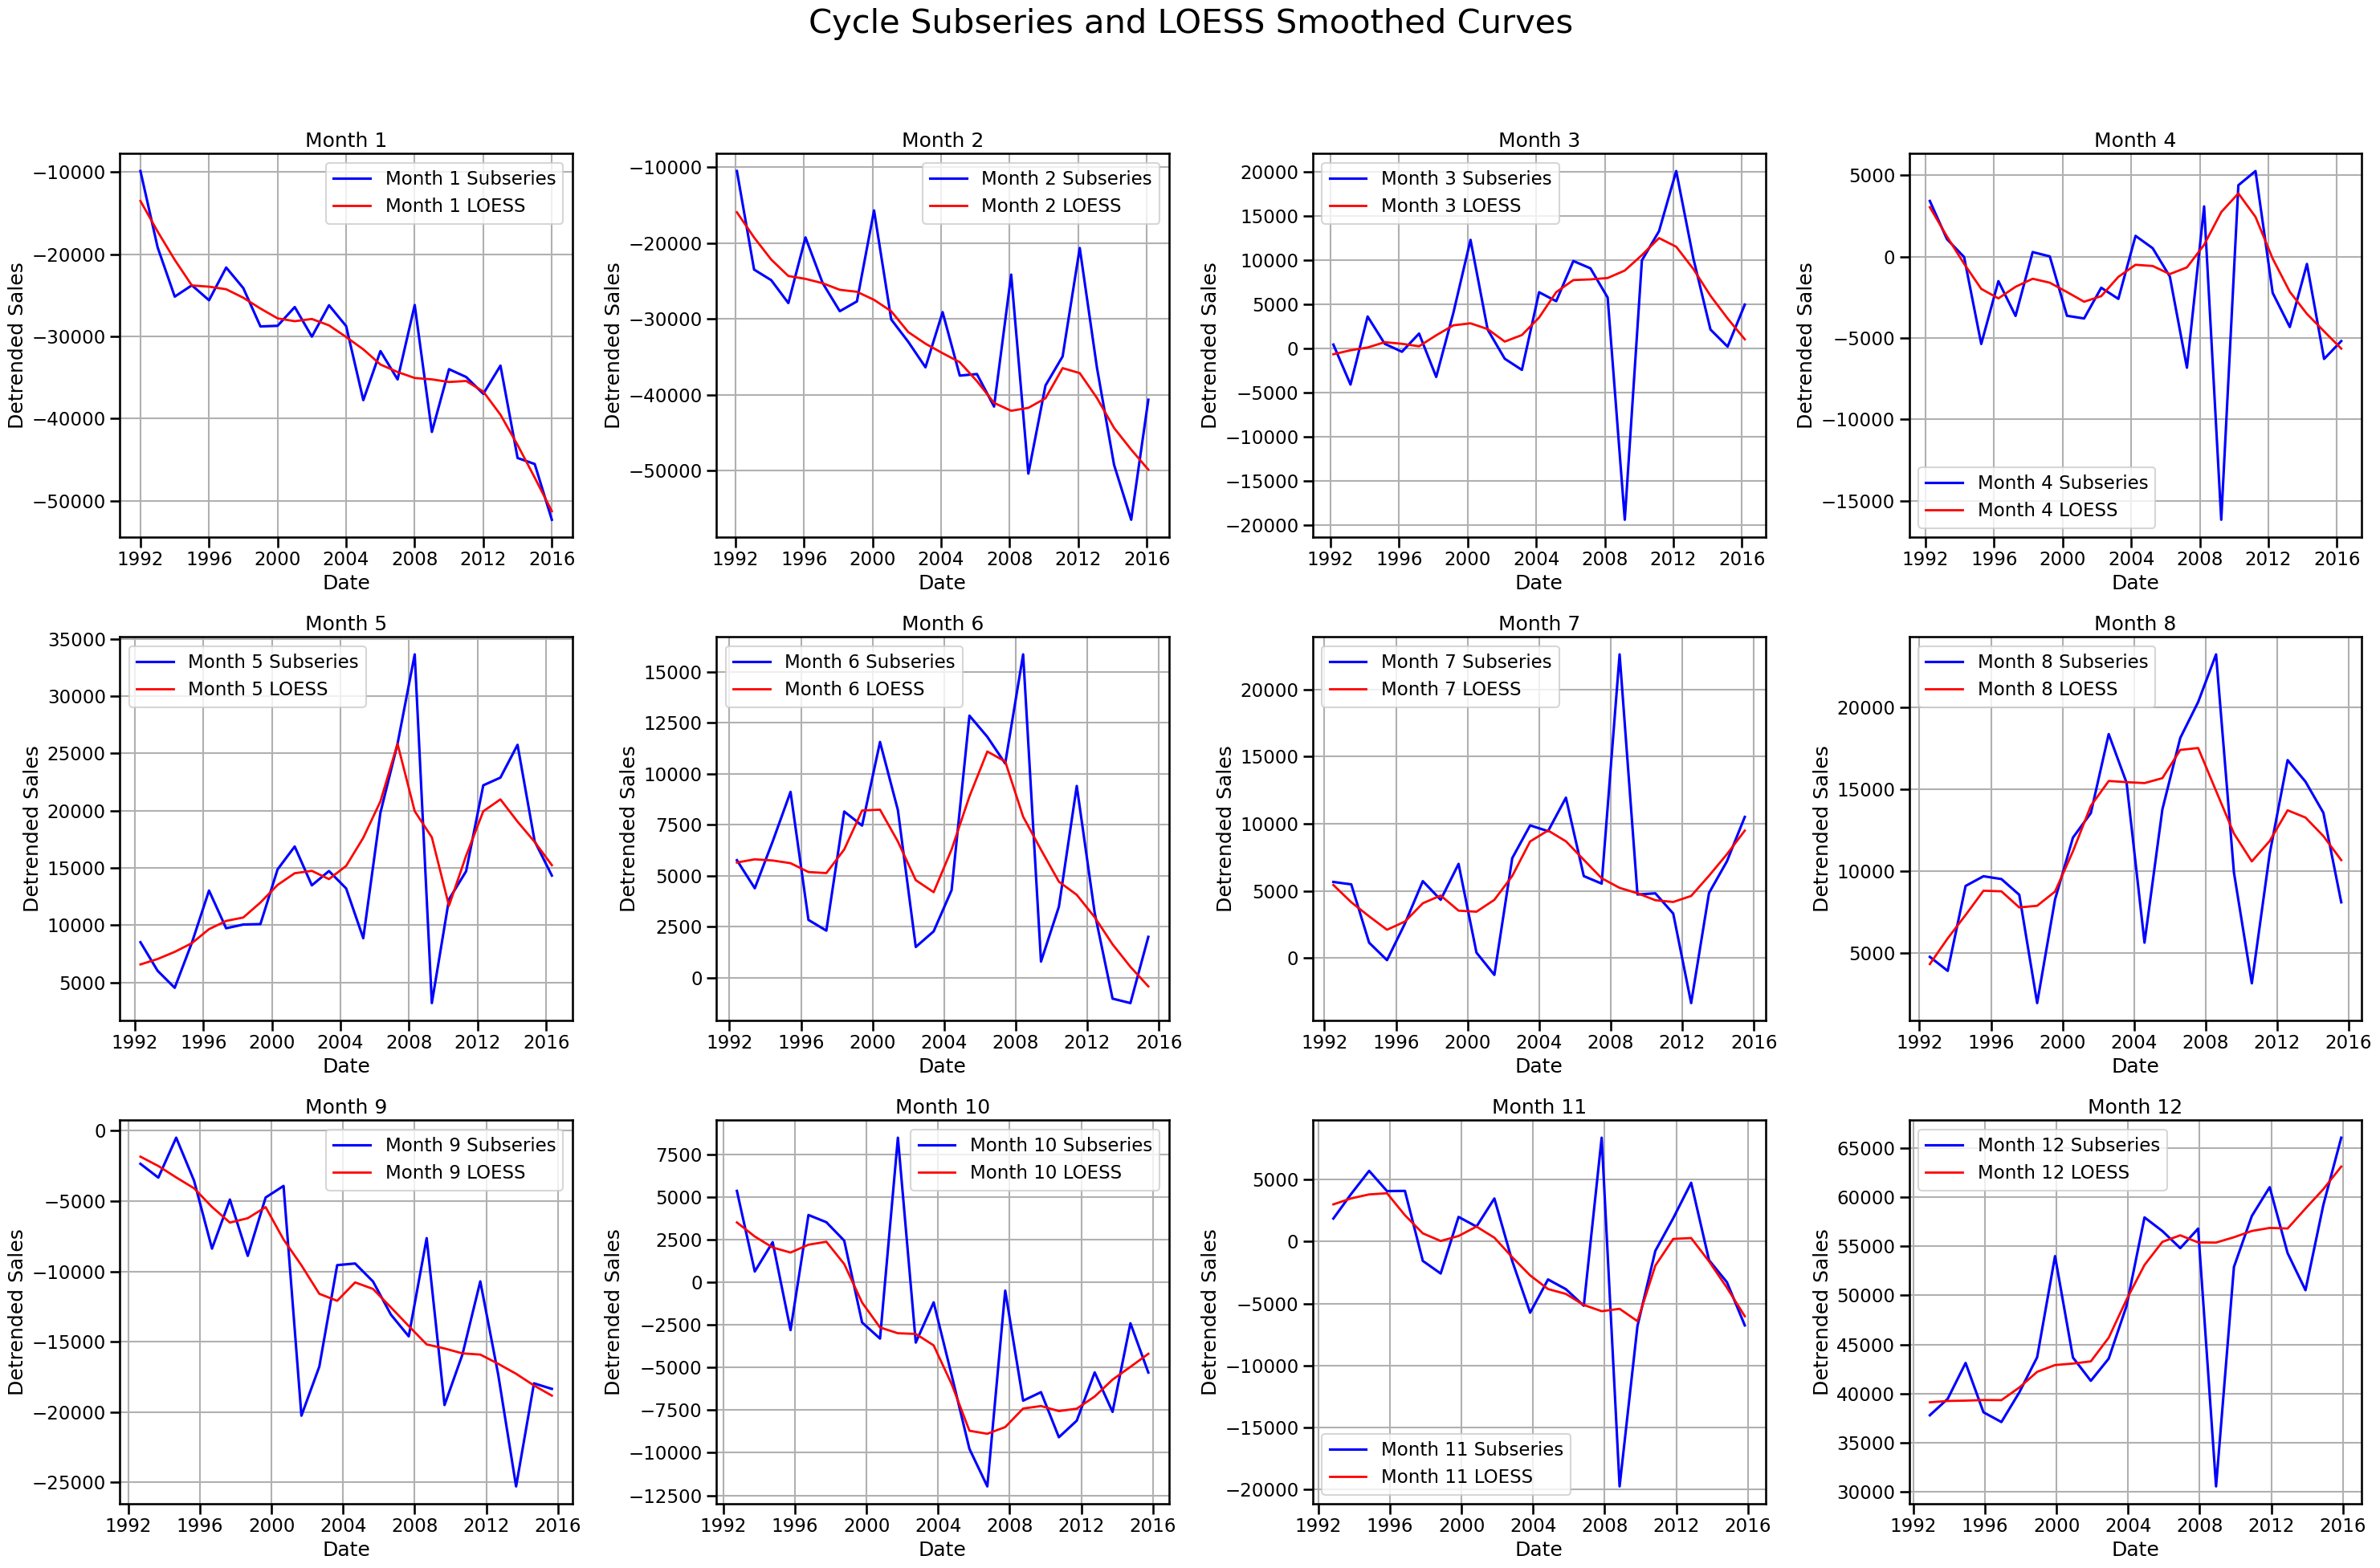

In [8]:
# Prepare a dictionary to store the cycle subseries for each month
cycle_subseries = {month: df[df['month'] == month]['Detrended_Sales'] for month in range(1, 13)}

# Apply LOESS smoothing to each month's subseries and plot them
fig, axs = plt.subplots(3, 4, figsize=(30, 20))
fig.suptitle('Cycle Subseries and LOESS Smoothed Curves', fontsize=30)

for month, ax in zip(range(1, 13), axs.flatten()):
    subseries = cycle_subseries[month]
    
    # Apply LOESS smoothing
    lowess_subseries = sm.nonparametric.lowess(subseries, subseries.index, frac=0.3)
    
    # Plot the original subseries
    ax.plot(subseries.index, subseries, label=f'Month {month} Subseries', color='blue')
    
    # Plot the LOESS smoothed curve
    ax.plot(subseries.index, lowess_subseries[:, 1], label=f'Month {month} LOESS', color='red', linewidth=2)
    
    ax.set_title(f'Month {month}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Detrended Sales')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


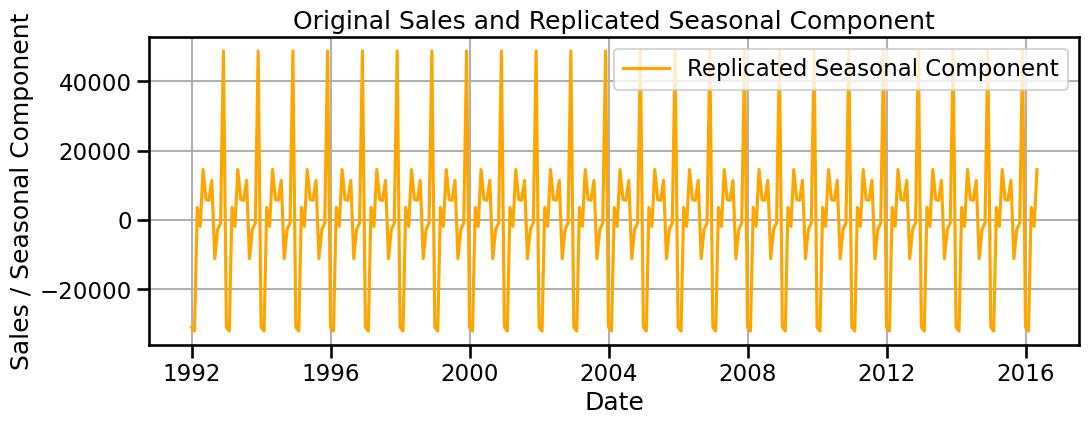

,y,Detrended_Sales,month,Seasonal_Component
ds,,,,
1992-01-01,146376,-9867.927417,1,-30904.597203
1992-02-01,147079,-10543.640842,2,-32021.469710
1992-03-01,159336,438.292443,3,3654.123229
1992-04-01,163669,3418.535832,4,-1832.264393
1992-05-01,170068,8512.243622,5,14578.994427


In [9]:
# Correctly compute the monthly averages
monthly_means_corrected = df.groupby('month')['Detrended_Sales'].mean().reset_index()

# Apply LOESS smoothing to these monthly averages
lowess_monthly_corrected = sm.nonparametric.lowess(
    monthly_means_corrected['Detrended_Sales'],
    monthly_means_corrected['month'],
    frac=0.3
)

# Create a DataFrame to store the smoothed seasonal component for each month
seasonal_component_corrected_df = pd.DataFrame({
    'Month': monthly_means_corrected['month'],
    'Seasonal_Component': lowess_monthly_corrected[:, 1]
})

# Create a seasonal component array for the entire dataset
seasonal_component_replicated_corrected = df['month'].map(
    seasonal_component_corrected_df.set_index('Month')['Seasonal_Component']
)

# Add the replicated seasonal component to the original DataFrame
df['Seasonal_Component'] = seasonal_component_replicated_corrected

# Plot the original data with the replicated seasonal component
plt.figure(figsize=(12, 4))
#plt.plot(df.index, df['y'], label='Original Sales', color='blue')
plt.plot(df.index, df['Seasonal_Component'], label='Replicated Seasonal Component', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales / Seasonal Component')
plt.title('Original Sales and Replicated Seasonal Component')
plt.legend()
plt.grid(True)
plt.show()

# Display the first few rows of the DataFrame with the new column
df.head()


### Step 5: Find the De-seasonalised series

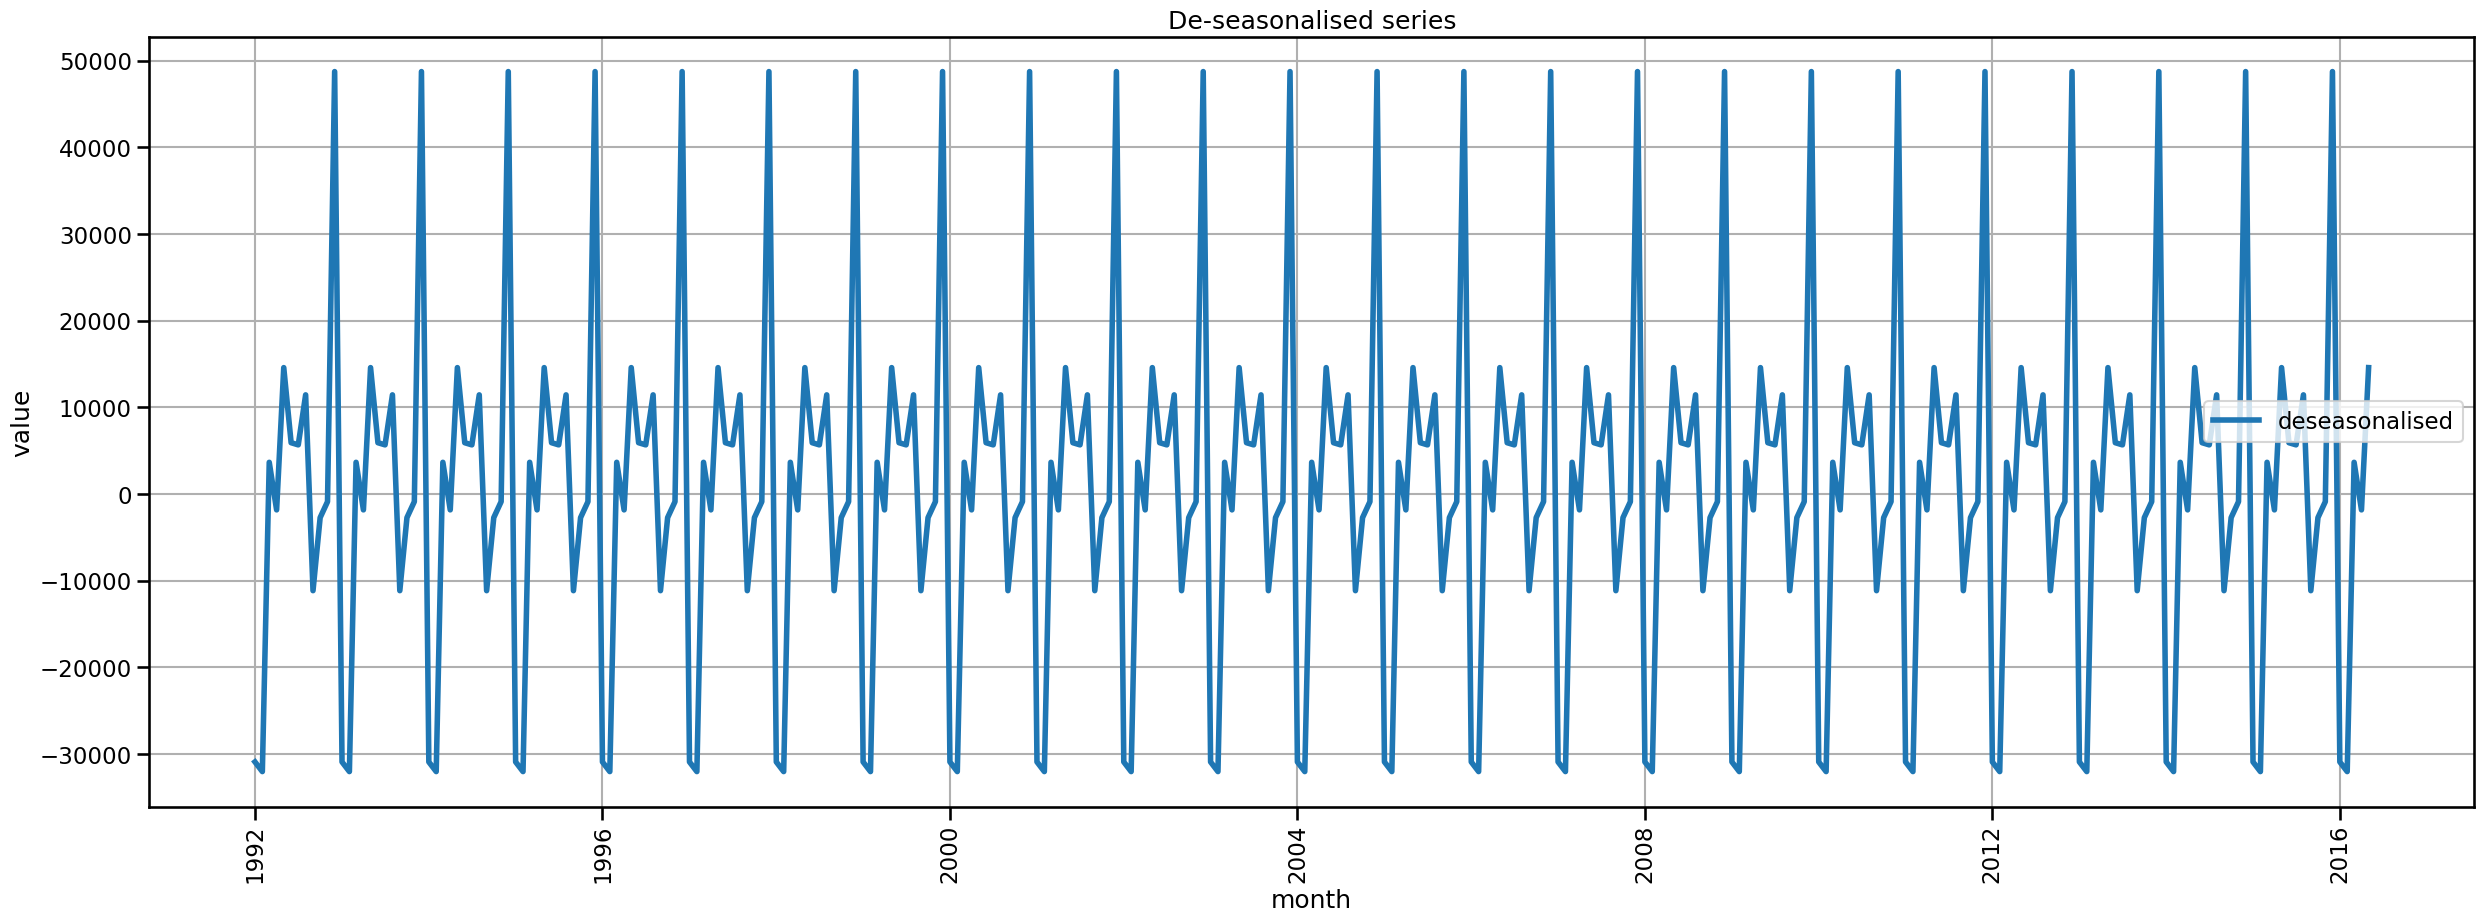

In [11]:
df['deseasonalised'] = df['y'] - df['Seasonal_Component']

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(df.index, df['Seasonal_Component'], marker='', linestyle='-', label='deseasonalised', linewidth=4)
plt.title("De-seasonalised series")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()